# Obligatorio
<h3><i>Machine learning</i> para Inteligencia Artificial</h3>

**Autores:**
- Germán Otero, N° de estudiante: 138796
- Sebastián Uriarte Güimil, N° de estudiante: 194973

**Nota:** La versión más reciente de este obligatorio, así como de los laboratorios/tareas
anteriores, se encuentran disponibles en
[este repositorio](https://github.com/sebassu/machine-learning-para-IA).

## 1. Introducción

El presente obligatorio, entregable final del curso, tiene como objetivo la aplicación
de los distintos conceptos, técnicas y modelos vistos como parte del contenido de la
materia, al análisis de un caso real. En particular, en esta ocasión el problema a
abordar es uno de clasificación de imágenes, en el marco de detección de rostros.

<img style="float: right; margin: 0px 0px 5px 10px" src="assets/haar_like_features.jpg">

La mayoría de las técnicas modernas para el procesamiento de imágenes involucran modelos
más complejos, como por ejemplo las populares redes neuronales convolucionales. Sin
embargo, también es posible obtener buenos resultados mediante agentes más sencillos,
que requerirán menores recursos computacionales. Para ello, una implementación posible
será simplemente iterando sobre toda ventana de la imagen original y ejecutando un
modelo que retorne si esta subimagen es la de un rostro o no, debiendo este clasificador
ser particularmente performante dado el gran número de llamadas se realizarán. Es en
este último aspecto que se centrará el presente trabajo.

En su _paper_ titulado "_Rapid Object Detection Using a Boosted Cascade of Simple
Features_", los autores Viola y Jones proponen el uso de las llamadas
**_Haar-like features_**. Brevemente, estas son funciones que transforman la imagen en
un valor numérico, resultante de la suma o resta de regiones rectangulares de
pixeles en escala de grises. Cada _feature_ tiene un identificador que define el número,
tamaño y coordenadas de estas regiones. Ejemplos de la mismas se muestran en la figura
presentada.

En esta tarea se utilizarán estas, obtenidas a partir de un _dataset_ de imagenes de
rostros y fondos, para entrenar modelos de _machine learning_ que las clasifiquen en
estas dos categorías. El objetivo final será subir estos resultados a la
[competencia de Kaggle](https://www.kaggle.com/competitions/obligatorio-mlia-2024)
asociada con el obligatorio.

## 2. Carga y transformación inicial de imágenes
En estas secciones subsiguientes se reutilizó y adaptó gran parte del código presentado
en clase; particularmente, aquél vinculado al laboratorio 2 y a distintas
_Jupyter notebooks_ en Aulas.

Para este obligatorio fue entregado un nuevo _dataset_, obtenible en
[este enlace](https://www.kaggle.com/competitions/obligatorio-mlia-2024/data). Dado que
su descarga requiere autenticación al estar bajo una competencia privada, se asume este
archivo `.zip` que contiene los datos fue descargado y se encuentra en la misma ruta que
esta _notebook_.

In [51]:
import os
import random
from glob import glob
from itertools import chain
from os import makedirs
from os.path import basename, exists
from random import randrange, seed, shuffle, sample
from shutil import copy2, rmtree
from time import time
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.pyplot import imread
from skimage import data
from skimage.color import rgb2gray, rgba2rgb
from skimage.exposure import equalize_hist
from skimage.feature import haar_like_feature, haar_like_feature_coord
from skimage.io import imsave
from skimage.transform import integral_image, resize
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.image import PatchExtractor
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from tqdm import tqdm

In [2]:
seed(42)
np.random.seed(42)

In [3]:
!unzip -oq ./obligatorio-mlia-2024.zip -d ./data
!mkdir ./data/Train ./data/Train/Original_Faces
!mv ./data/Faces/Faces/*.pgm ./data/Train/Original_Faces
!mv ./data/Test/Test/*.pgm ./data/Test
!rm -rf ./data/Faces
!rm -rf ./data/Test/Test

### 2.1 Escalado de imágenes
Una primera obseservación (algo obvia) que surge es que, a diferencia del laboratorio 2,
las imágenes bajo `/Test` no están etiquetadas las categorías `Face` y `Non-face`. Esto
resulta evidente puesto que esto es el resultado a determinar para la competencia en
Kaggle.

Otro punto a considerar es que, también a diferencia  del laboratorio 2, las imágenes de
rostros dentro de `Train` tienen tamaño `64 x 64`, mientras que las de `Test` son de
`19 x 19`. Esto se considera puede discrepancias entre el proceso de entrenamiento y la
posterior evaluación, al generar la salida a subirse a Kaggle.

Si bien las _features_ a generarse toman una ventana limitada de la imagen para calcular
el valor asociado, potencialmente a partir de imágenes de tamaño `64 x 64` sería posible
calcular _features_ que, por su tamaño o coordenadas, en una de `19 x 19` no se podría
(que, por ejemplo, se encontrarían por fuera de la imagen o excederían su tamaño).
Puesto entonces que estaríamos entranando al modelo con información luego no disponible
en `Test`, lo cual representa un problema. Por esto, se resuelve escalar las imágenes de
`Train` al tamaño de las de `Test`, `19 x 19`, de la siguiente forma:

In [4]:
SOURCE_PATH, OUTPUT_PATH = "./data/Train/Original_Faces", "./data/Train/Faces"
if exists(OUTPUT_PATH):
    rmtree(OUTPUT_PATH)
makedirs(OUTPUT_PATH)

for path in tqdm(glob(f"{SOURCE_PATH}/*.pgm")):
    image_data = resize(image=imread(path), output_shape=(19, 19))
    image = Image.fromarray(image_data, mode="L")
    image.save(f"{OUTPUT_PATH}/{basename(path)}")
rmtree(SOURCE_PATH)

100%|██████████| 12833/12833 [27:12<00:00,  7.86it/s]   


### 2.2 Creación de imágenes de fondos
Una segunda inconveniencia que tiene el _dataset_ de este obligatorio es que, a
diferencia del anterior, las imágenes de `Train` consisten únicamente de rostros. Por
tanto, será necesario generar imágenes de fondos para poder entrenar apropiadamente los
modelos a obtenerse. Para ello se utilizará la estrategia presentada en _notebooks_ en
Aulas, y las imágenes de
[_Backgrounds_](https://aulas.ort.edu.uy/mod/resource/view.php?id=517711); en escencia
generando recortes de tamaño `19 x 19` de imágenes que no contienen rostros. A esto
agregaremos también las imágenes del _dataset_ del laboratorio 2, tanto para rostros
como para no rostros, que podemos reutilizar para este.

Un punto a discutir es el número total de imágenes a generar. Dado que el clasificador a
entrenarse sería utilizado con un detector que haría llamadas con ventanas arbitrarias
de una imagen dada, donde habría a lo sumo unos pocos rostros frente a una cantidad
mucho mayor de ventanas, resulta razonable tener una cantidad muy superior de fondos
frente a rostros. Para el laboratorio 2, se tenía que:

<div style="margin: auto; width: 50%">

| **_Data Set_** | **_Faces_** | **_Non-faces_** |
| :------------: | :---------: | :-------------: |
|  **_Train_**   |    2429     |      4548       |
|   **_Test_**   |     472     |      23573      |

</div>

Donde se observa que hay mucho mayor cantidad de imágenes `Non-face` (fondos) que `Face`
(rostros) en ambos `Train` y `Test`. Dado que los resultados obtenidos en el
entrenamiento del laboratorio 2 fueron buenos, se mantendrá una proporción entre clases
similar en este obligatorio, en lugar de utilizar la de `Test` directamente, por
ejemplo (asumiendo que esta tal vez se mantenga para los datos de `Test` a tratarse en
esta ocasión).

Esto además como para no generar una cantidad considerada excesiva (aproximadamente 50
veces más, que dado que hay $12833$ imágenes de rostros resultaría en $640916$ imágenes
de fondos), y además porque la presencia de una clase muy desbalanceada puede afectar
negativamente al entrenamiento, haciendo que el modelo no capture correctamente sus
características y en cambio se decante por la clase más frecuente cuando no debiera.

Dado que tomamos las imágenes del laboratorio 2 como parte del _dataset_ a formar,
tenemos que los totales parciales son por ahora $12833+2429+472=15734$ imágenes de
rostros, y $23573+4548=28121$ imágenes de fondos. La proporción para el laboratorio 2
sería $4548/2429 \approx 2$, por lo que se precisaría generar
$2*15734-28121=\textbf{3347}$ imágenes, obteniéndose en resumen:

<div style="margin: auto; width: 50%; text-align: center">
    <table>
        <thead>
            <tr>
                <th><i>Data Set</i></th>
                <th><i>Faces</i></th>
                <th><i>Non-faces</i></th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td><b><i>Train</b></i></td>
                <td>15734</td>
                <td>31468</td>
            </tr>
            <tr>
                <td><b><i>Test</b></i></td>
                <td colspan=2>7920</td>
            </tr>
        </tbody>
    </table>
</div>


In [5]:
BACKGROUNDS_DIRECTORY = "./data/Train/Non_Faces"

if not exists(BACKGROUNDS_DIRECTORY):
    makedirs(BACKGROUNDS_DIRECTORY)

directories = {
    "../laboratorios/2/{0}/face": "./data/Train/Faces",
    "../laboratorios/2/{0}/non-face": BACKGROUNDS_DIRECTORY,
}

for dataset in ["train", "test"]:
    for source, destination in directories.items():
        for path in tqdm(glob(f"{source.format(dataset)}/*.pgm")):
            copy2(path, destination)

100%|██████████| 23573/23573 [00:21<00:00, 1097.80it/s]


In [6]:
!unzip -oq ./Background.zip -d ./assets/Backgrounds

images_to_generate, image_size = 3347, (19, 19)
background_image_names = [
    "binary_blobs",
    "brick",
    "colorwheel",
    "cat",
    "checkerboard",
    "chelsea",
    "clock",
    "coffee",
    "coins",
    "grass",
    "gravel",
    "horse",
    "hubble_deep_field",
    "immunohistochemistry",
    "logo",
    "moon",
    "page",
    "text",
    "rocket",
]


def is_rgb(image: np.ndarray) -> bool:
    return len(image.shape) == 3 and image.shape[2] == 3


def is_rgba(image: np.ndarray) -> bool:
    return len(image.shape) == 3 and image.shape[2] == 4


def convert_to_grayscale(image: np.ndarray) -> np.ndarray:
    return (
        rgb2gray(rgba2rgb(image))
        if is_rgba(image)
        else rgb2gray(image) if is_rgb(image) else image
    )


def get_random_counts(count: int, total: int) -> np.ndarray:
    random_numbers = np.random.rand(count) + 1
    current_sum = np.sum(random_numbers)
    numbers = np.floor(random_numbers * (total / current_sum)).astype(int)
    for _ in range(total - np.sum(numbers)):
        numbers[randrange(0, count)] += 1
    return numbers


skimage_background_images = (getattr(data, name)() for name in background_image_names)
custom_background_images = (imread(path) for path in glob("./assets/Backgrounds/*.jpg"))
raw_background_images = [
    convert_to_grayscale(image)
    for image in chain(skimage_background_images, custom_background_images)
]
shuffle(raw_background_images)

counts, patches = get_random_counts(len(raw_background_images), images_to_generate), []
for image, count in zip(raw_background_images, counts):
    extractor = PatchExtractor(patch_size=image_size, max_patches=count)
    patches.append(extractor.transform(image[np.newaxis]))

for i, image_data in enumerate(np.vstack(patches)):
    generated_image = Image.fromarray(image_data, mode="L")
    generated_image.save(f"./data/Train/Non_Faces/generated_image_{i}.pgm")
rmtree("./assets/Backgrounds")

## 3. Generación de _Haar-like features_
Una vez se cuenta con las imágenes con las que se habrá de trabajar, es necesario
calcular las _features_ sobre las que se habrán de entrenar los distintos modelos.
Nuevamente recurriendo a lo realizado en el laboratorio 2, esto se puede hacer de la
siguiente manera:

### 3.1 Inicialización de _datasets_ desde archivos

In [7]:
def _clear_all_variables():
    variables = globals().copy()
    for identifier, variable in variables.items():
        if identifier[0] != "_":
            del variable


_clear_all_variables()

faces_train_paths = glob("./data/Train/Faces/*.pgm")
backgrounds_train_paths = glob("./data/Train/Non_Faces/*.pgm")
test_filenames = glob("./data/Test/*.pgm")

print(f"Train faces total count: {len(faces_train_paths)}")
print(f"Train backgrounds (non-faces) total count: {len(backgrounds_train_paths)}")
print(f"Test images count: {len(test_filenames)}")

Train faces total count: 15734
Train backgrounds (non-faces) total count: 31468
Test images count: 7920


In [29]:
# En caso de desear un subconjunto de las imágenes de entrenamiento
fraction = 0.05
assert 0 < fraction <= 1

faces_count = round(fraction * len(faces_train_paths))
backgrounds_count = round(fraction * len(backgrounds_train_paths))
faces_train_paths = sample(faces_train_paths, faces_count)
backgrounds_paths = sample(backgrounds_train_paths, backgrounds_count)

print(f"Train faces sample size: {len(faces_train_paths)}")
print(f"Train backgrounds (non-faces) sample size: {len(backgrounds_paths)}")

Train faces sample size: 79
Train backgrounds (non-faces) sample size: 1573


In [30]:
train_images = [
    imread(path) for path in tqdm(chain(backgrounds_paths, faces_train_paths))
]
y_train = [0] * len(backgrounds_paths) + [1] * len(faces_train_paths)
test_images = [imread(path) for path in tqdm(test_filenames)]

print(f"\nTrain counts: {len(train_images)}, {len(y_train)}")

1652it [00:02, 814.81it/s]
100%|██████████| 7920/7920 [00:09<00:00, 827.14it/s] 


Train counts: 1652, 1652


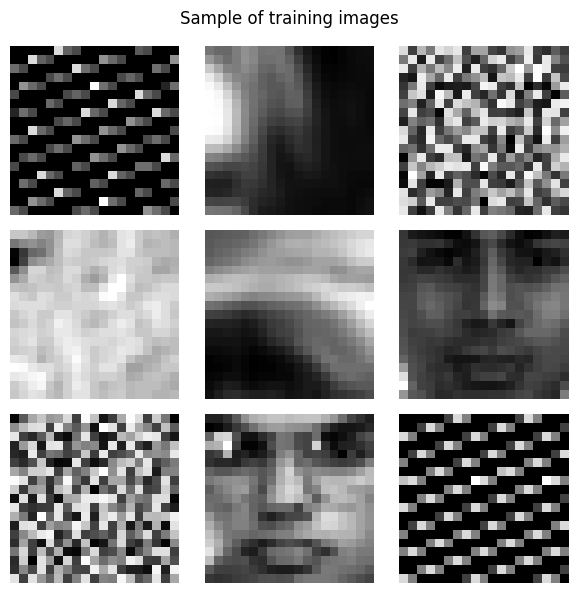

In [26]:
def sample_images_and_show_from(dataset: list[np.ndarray], title: str) -> None:
    sampled_images = sample(dataset, 9)
    _, axes = plt.subplots(3, 3, figsize=(6, 6))
    for ax, img in zip(axes.flatten(), sampled_images):
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


sample_images_and_show_from(train_images, "Sample of training images")

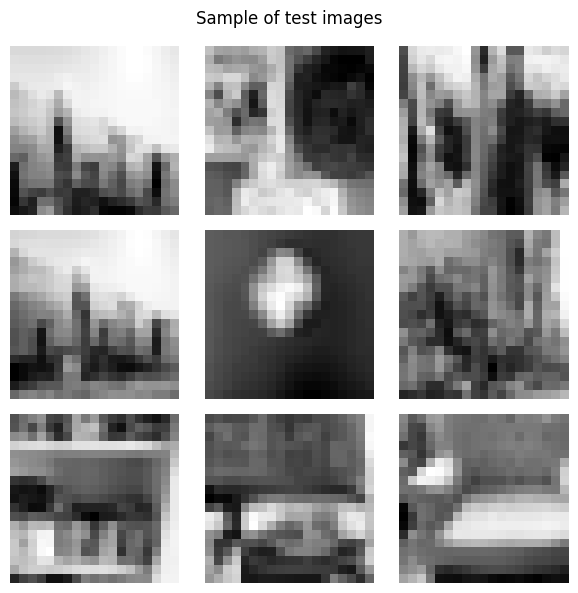

In [186]:
sample_images_and_show_from(test_images, "Sample of test images")

### 3.2 _Histogram equalization_

In [31]:
def process_images(images: list[np.ndarray]) -> list[np.ndarray]:
    return [integral_image(equalize_hist(image)) for image in tqdm(images)]


train_images_integral = process_images(train_images)
test_images_integral = process_images(test_images)
del train_images, test_images

100%|██████████| 7920/7920 [00:01<00:00, 7501.14it/s]


### 3.3 Cálculo de matriz de _features_
Para esta sección, se calcularán las _Haar-like features_ para las imágenes a
considerar, según se presentará a continuación. Una consideración a tener, sin embargo,
es cuantas de ellas utilizar para el posterior entrenamiento, y como seleccionarlas.

Para ello, utilizaremos la estrategia presentada en el laboratorio 2, que utiliza la
correlación entre cada _feature_ con la variable a predecir como métrica sobre la cual
elegir un cierto percentil de todas ellas, priorizándose aquellas donde este valor sea
mayor. El artículo de Viola y Jones, asimismo, menciona utilizar en su clasificador
final un total de 6061 _features_ por lo que buscaremos seleccionar una cantidad igual
o superior a esta.

In [45]:
def extract_features_from(image, feature_type=None, feature_coord=None) -> np.ndarray:
    return haar_like_feature(
        image,
        0,
        0,
        image.shape[0],
        image.shape[1],
        feature_type=feature_type,
        feature_coord=feature_coord,
    )


X_train = np.array([extract_features_from(img) for img in tqdm(train_images_integral)])
np.save("X_train.npy", X_train)

100%|██████████| 1652/1652 [05:00<00:00,  5.50it/s]


In [ ]:
FEATURE_PERCENTILE = 1

start_time = time()
index_selected_features = (
    SelectPercentile(f_classif, percentile=FEATURE_PERCENTILE)
    .fit(X_train, y_train)
    .get_support(indices=True)
)
X_train = X_train[:, index_selected_features]
time_elapsed = time() - start_time

print(f"Seleccionadas {X_train.shape[1]} features potenciales")
print(f"Tiempo: {time_elapsed} segundos")

Seleccionadas 640 features potenciales
Tiempo: 4.8660972118377686 segundos


Algo que puede ser interesante es ver los valores que adoptan cada feature, además de la
correlación entre features. Para ello:

In [77]:
feature_dataframe = pd.DataFrame(X_train)
feature_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
0,0.000000,-2.220446e-16,4.440892e-16,0.000000,0.288089,0.063712,-0.160665,-2.220446e-16,-2.220446e-16,-4.440892e-16,...,-0.066482,-0.013850,0.069252,0.022161,-0.013850,3.552714e-15,5.540166e-02,0.000000e+00,1.421085e-14,-0.002770
1,-0.044321,2.077562e-01,-4.986150e-02,-0.022161,-0.121884,-0.033241,-0.207756,-2.216066e-02,2.022161e-01,-4.432133e-02,...,-0.033241,0.022161,-0.202216,-0.360111,-0.022161,3.324100e-02,-4.432133e-02,5.540166e-03,-2.216066e-02,0.108033
2,0.060942,2.216066e-02,3.047091e-02,-0.063712,0.047091,-0.130194,-1.022161,0.000000e+00,1.662050e-02,3.047091e-02,...,0.033241,-0.047091,0.052632,0.047091,0.005540,-3.324100e-02,-3.324100e-02,-1.421085e-14,-3.601108e-02,-0.008310
3,0.130194,0.000000e+00,1.357341e-01,0.000000,0.000000,0.185596,0.000000,6.925208e-02,1.274238e-01,6.925208e-02,...,0.000000,0.008310,0.005540,0.002770,-0.002770,1.662050e-02,-1.776357e-14,5.540166e-03,-1.421085e-14,0.002770
4,-0.146814,-2.220446e-16,-2.493075e-02,0.063712,0.000000,-0.008310,-0.072022,1.135734e-01,5.540166e-03,-4.709141e-02,...,-0.011080,0.019391,-0.196676,-0.083102,-0.005540,-2.770083e-02,-9.141274e-02,4.986150e-02,2.493075e-02,-0.055402


In [50]:
feature_dataframe.describe()

,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
count,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,...,1652.000000,1652.000000,1.652000e+03,1.652000e+03,1.652000e+03,1.652000e+03,1652.000000,1652.000000,1.652000e+03,1652.000000
mean,-0.073084,0.055940,-0.044777,-0.094879,0.027300,-0.067414,0.067901,-0.078642,0.038100,-0.069173,...,-0.061473,0.062152,-7.780379e-02,-6.562682e-02,-6.175676e-02,6.390977e-02,-0.070382,0.065691,-6.435413e-02,0.063003
std,0.319582,0.181741,0.212211,0.317796,0.201474,0.208327,0.406681,0.280191,0.202736,0.208252,...,0.229833,0.241429,5.065385e-01,3.761946e-01,2.453132e-01,2.352817e-01,0.235409,0.229109,2.370791e-01,0.225918
min,-1.457064,-0.559557,-0.703601,-1.459834,-0.767313,-0.709141,-1.470914,-1.468144,-0.800554,-0.703601,...,-1.404432,-0.562327,-3.371191e+00,-2.204986e+00,-1.434903e+00,-6.204986e-01,-1.473684,-0.537396,-1.565097e+00,-0.584488
25%,-0.158587,-0.024931,-0.080332,-0.207756,-0.058172,-0.110803,-0.124654,-0.133657,-0.055402,-0.102493,...,-0.066482,-0.027701,-1.994460e-01,-1.329640e-01,-5.817175e-02,-1.662050e-02,-0.063712,-0.019391,-5.817175e-02,-0.019391
50%,-0.018006,0.019391,0.000000,-0.037396,0.000000,-0.011080,0.015235,-0.022161,0.000000,-0.011080,...,-0.005540,0.002770,-2.842171e-14,-9.237056e-14,-5.684342e-14,4.440892e-15,-0.005540,0.005540,-5.684342e-14,0.001385
75%,0.072715,0.105263,0.060942,0.060942,0.069252,0.027701,0.213296,0.047091,0.072022,0.038781,...,0.024931,0.058172,1.558172e-01,8.587258e-02,3.324100e-02,4.155125e-02,0.022161,0.064404,2.493075e-02,0.055402
max,1.268698,0.861496,0.686981,1.218837,0.914127,0.603878,2.088643,1.548476,0.900277,0.645429,...,0.637119,1.620499,1.833795e+00,1.684211e+00,7.756233e-01,1.620499e+00,0.540166,1.620499,6.731302e-01,1.620499


In [103]:
correlation_matrix = feature_dataframe.corr()
display(correlation_matrix)

high_correlations_mask = (correlation_matrix > 0.85) | (correlation_matrix < -0.85)
np.fill_diagonal(high_correlations_mask.values, False)
high_correlations = high_correlations_mask.stack()
high_correlations = high_correlations[high_correlations]

print(f"High correlation features count: {len(high_correlations) // 2}")

,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
0,1.000000,-0.353285,0.345510,0.326891,-0.323615,0.405855,-0.267283,0.241139,-0.158693,0.826918,...,0.365823,-0.324317,0.254498,0.290963,0.367070,-0.355003,0.354818,-0.369060,0.383885,-0.346132
1,-0.353285,1.000000,-0.333375,-0.262681,0.358182,-0.436349,0.214167,-0.298221,0.300674,-0.496126,...,-0.401427,0.397022,-0.222123,-0.256452,-0.361734,0.411048,-0.374215,0.400594,-0.380231,0.370746
2,0.345510,-0.333375,1.000000,0.384586,-0.525243,0.660270,-0.328967,0.459484,-0.563766,0.609092,...,0.596339,-0.599778,0.437388,0.456726,0.602055,-0.637461,0.577995,-0.568980,0.566291,-0.602856
3,0.326891,-0.262681,0.384586,1.000000,-0.383849,0.351686,-0.209994,0.290927,-0.327136,0.451715,...,0.360633,-0.330443,0.262709,0.309890,0.349900,-0.376158,0.364998,-0.294226,0.363397,-0.323073
4,-0.323615,0.358182,-0.525243,-0.383849,1.000000,-0.387169,0.185904,-0.347734,0.423335,-0.510003,...,-0.421426,0.482090,-0.308986,-0.287035,-0.455110,0.465840,-0.436553,0.405030,-0.461913,0.479040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,-0.355003,0.411048,-0.637461,-0.376158,0.465840,-0.612699,0.307589,-0.389501,0.473869,-0.626500,...,-0.600537,0.598292,-0.389979,-0.359467,-0.558453,1.000000,-0.592290,0.581725,-0.545964,0.639700
636,0.354818,-0.374215,0.577995,0.364998,-0.436553,0.598820,-0.271771,0.377045,-0.454299,0.608370,...,0.544712,-0.521460,0.395674,0.431592,0.627586,-0.592290,1.000000,-0.565310,0.553081,-0.520733
637,-0.369060,0.400594,-0.568980,-0.294226,0.405030,-0.574593,0.307343,-0.347179,0.422035,-0.585881,...,-0.485074,0.596158,-0.383625,-0.361625,-0.541771,0.581725,-0.565310,1.000000,-0.504726,0.595860
638,0.383885,-0.380231,0.566291,0.363397,-0.461913,0.569926,-0.270538,0.374790,-0.485933,0.595250,...,0.547510,-0.490109,0.376239,0.382598,0.522149,-0.545964,0.553081,-0.504726,1.000000,-0.541456


High correlation features count: 129


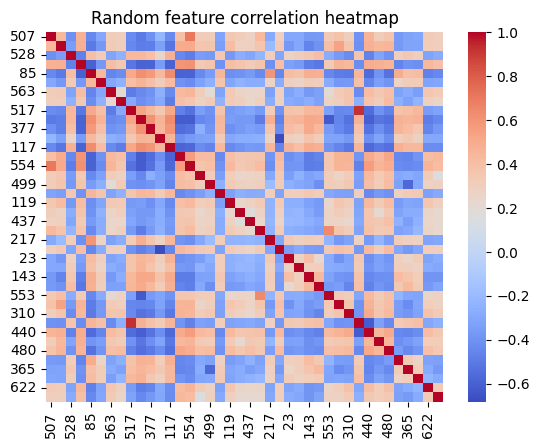

In [102]:
sampled_columns = feature_dataframe.sample(n=40, axis=1)
correlation_matrix = sampled_columns.corr()
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.title("Random feature correlation heatmap")
plt.show()

In [106]:
feature_coord, feature_type = haar_like_feature_coord(width=19, height=19)
X_to_predict = [
    extract_features_from(
        image,
        feature_type=feature_type[index_selected_features],
        feature_coord=feature_coord[index_selected_features],
    )
    for image in tqdm(test_images_integral)
]
X_to_predict = np.array(X_test)

100%|██████████| 7920/7920 [00:19<00:00, 404.59it/s]


___

## Entrenamiento de modelos

La propuesta del presente laboratorio 2 pide entrenar (al menos) un modelo que permita
abordar el problema de clasificación de imágenes en rostros y no rostros, en función de
las _features_ obtenidas en celdas anteriores. Para ello, podemos considerar lo
siguiente:

In [ ]:
def test_model_with(model, parameters: dict):
    search = GridSearchCV(model, parameters, scoring="f1")
    search.fit(X_train, y_train)
    print(f"Best parameters: {search.best_params_}")
    print(f"Best score: {search.best_score_}")

    y_pred = search.best_estimator_.predict(X_test)
    print(f"Accuracy score: {accuracy_score(y_test, y_pred)}\n")
    print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}\n")
    print(f"Classification Report:\n {classification_report(y_test, y_pred)}")
    return search.best_estimator_

### _Decision Tree_

In [ ]:
model = DecisionTreeClassifier()
parameters = {
    "criterion": ["gini", "log_loss"],
    "max_depth": [None, 5],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [2, 4, 6],
    "class_weight": ["balanced"],
}

best_decision_tree = test_model_with(model, parameters)
plot_tree(
    best_decision_tree,
    filled=True,
    class_names=["Non-face", "Face"],
)
plt.show()

### _Random Forest_

In [ ]:
model = RandomForestClassifier()
parameters = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 10],
    "min_samples_split": [2, 6],
    "min_samples_leaf": [1, 4],
    "class_weight": ["balanced"],
}

best_random_forest = test_model_with(model, parameters)

### _Gradient Boosting_

In [ ]:
model = GradientBoostingClassifier()
parameters = {
    "learning_rate": [0.2, 0.1, 0.05],
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [3, 5, 10],
}

best_gradient_boosting = test_model_with(model, parameters)

# Red neuronal

A continuación, realizamos diferentes pruebas con redes neuronales para evaluar la performance de otros modelos para tener como referencia.
